*Note: With the current version of Torch, only CPU is availabe for geometric.*

This directory contains the a selection of the Cora dataset (www.research.whizbang.com/data).

The Cora dataset consists of Machine Learning papers. These papers are classified into one of the following seven classes:
		Case_Based
		Genetic_Algorithms
		Neural_Networks
		Probabilistic_Methods
		Reinforcement_Learning
		Rule_Learning
		Theory

The papers were selected in a way such that in the final corpus every paper cites or is cited by atleast one other paper. There are 2708 papers in the whole corpus. 

After stemming and removing stopwords we were left with a vocabulary of size 1433 unique words. All words with document frequency less than 10 were removed.


THE DIRECTORY CONTAINS TWO FILES:

The .content file contains descriptions of the papers in the following format:

		<paper_id> <word_attributes>+ <class_label>

The first entry in each line contains the unique string ID of the paper followed by binary values indicating whether each word in the vocabulary is present (indicated by 1) or absent (indicated by 0) in the paper. Finally, the last entry in the line contains the class label of the paper.

The .cites file contains the citation graph of the corpus. Each line describes a link in the following format:

		<ID of cited paper> <ID of citing paper>

Each line contains two paper IDs. The first entry is the ID of the paper being cited and the second ID stands for the paper which contains the citation. The direction of the link is from right to left. If a line is represented by "paper1 paper2" then the link is "paper2->paper1". 

In [1]:
%%shell

wget "https://web.archive.org/web/20150918182409/http://www.cs.umd.edu/~sen/lbc-proj/data/cora.tgz"
tar -xzvf cora.tgz

pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cpu.html
pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cpu.html
pip install torch-geometric

pip install networkx

pip install icecream
pip install tqdm

--2021-12-06 17:16:19--  https://web.archive.org/web/20150918182409/http://www.cs.umd.edu/~sen/lbc-proj/data/cora.tgz
Resolving web.archive.org (web.archive.org)... 207.241.237.3
Connecting to web.archive.org (web.archive.org)|207.241.237.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘cora.tgz.1’

cora.tgz.1              [      <=>           ] 163.15K  94.1KB/s    in 1.7s    

2021-12-06 17:16:28 (94.1 KB/s) - ‘cora.tgz.1’ saved [167063]

cora/
cora/README
cora/cora.content
cora/cora.cites
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cpu.html
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cpu.html


In [2]:
import numpy as np
import pandas as pd
import random
from icecream import ic
from tqdm.notebook import tqdm   

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch_geometric
import networkx as nx

import scipy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt


print("Torch version:", torch.__version__)
print("CUDA Present:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)

Torch version: 1.10.0+cu111
CUDA Present: True
CUDA Version: 11.1


In [37]:
CONFIG = {
    'PATH': './cora',
    'LIMIT': 250,
    'HIDDEN_CHANNELS': 1024,
    'NUM_LAYERS': 2,
    'DROPOUT_RATE': 0,
    'EPOCHS': 500
}

print("Here's the configuration: ")
for k, v in CONFIG.items():
    print(f"{k} = {v}")

Here's the configuration: 
PATH = ./cora
LIMIT = 250
HIDDEN_CHANNELS = 1024
NUM_LAYERS = 2
DROPOUT_RATE = 0
EPOCHS = 500


In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
text = """ When I wake up, the other side of the bed is cold. My fingers stretch out, seeking Prims warmth but finding only the rough canvas cover of the mattress. She must have had bad dreams and climbed in with our mother. Of course, she did. This is the day of the reaping. I prop myself up on one elbow. Theres enough light in the bedroom to see them. My little sister, Prim, curled up on her side, cocooned in my mothers body, their cheeks pressed together. In sleep, my mother looks younger, still worn but not so beaten-down. Prims face is as fresh as a raindrop, as lovely as the primrose for which she was named. My mother was very beautiful once, too. Or so

they tell me. Sitting at Prims knees, guarding her, is the worlds ugliest cat. Mashed-in nose, half of one ear missing, eyes the color of rotting squash. Prim named him Buttercup, insisting that his muddy yellow coat matched the bright flower. I he hates me. Or at least distrusts me. Even though it was years ago, I think he still remembers how I tried to drown him in a bucket when Prim brought him home. Scrawny kitten, belly swollen with worms, crawling with fleas. The last thing I needed was another mouth to feed. But Prim begged so hard, cried even, I had to let him stay. It turned out okay. My mother got rid of the vermin and hes a born mouser. Even catches the occasional rat. Sometimes, when I clean a kill, I feed Buttercup the entrails. He has stopped hissing at me. Entrails. No hissing. This is the closest we will ever come to love. I swing my legs off the bed and slide into my hunting boots. Supple leather that has molded to my feet. I pull on trousers, a shirt, tuck my long dark braid up into a cap, and grab my forage bag. On the table, under a wooden bowl to protect it from hungry rats and cats alike, sits a perfect little goat cheese wrapped in basil leaves. Prims gift to me on reaping day. I put the cheese carefully in my pocket as I slip outside. Our part of District 12, nicknamed the Seam, is usually crawling with coal miners heading out to the morning shift at this hour. Men and women with hunched shoulders, swollen knuckles, many who have long since stopped trying to scrub the coal dust out of their broken nails, the lines of their sunken faces. But today the black cinder streets are empty. Shutters on the squat gray houses are closed. The reaping isnt until two. May as well sleep in. If you can. Our house is almost at the edge of the Seam. I only have to pass a few gates to reach the scruffy field called the Meadow. Separating the Meadow from the woods, in fact enclosing all of District 12, is a high chain-link fence topped with barbed-wire loops. In theory, its supposed to be electrified twenty-four hours a day as a deterrent to the predators that live in the woods packs of wild dogs, lone cougars, bears that used to threaten our streets. But since were lucky to get two or three hours of electricity in the evenings, its

usually safe to touch. Even so, I always take a moment to listen carefully for the hum that means the fence is live. Right now, its silent as a stone. Concealed by a clump of bushes, I flatten out on my belly and slide under a two-foot stretch thats

been loose for years. There are several other weak spots in the fence, but this one is so close to home I almost always enter the woods here. As soon as Im in the trees, I retrieve a bow and sheath of arrows from a hollow log. Electrified or not, the fence has been successful at keeping the flesh-eaters out of District 12. Inside the woods they roam freely, and there are added concerns like venomous snakes, rabid animals, and no real paths to follow. But theres also food if you know how to find it. My father knew and he taught me some before he was blown to bits in a mine explosion. There was nothing even to bury. I was eleven then. Five years later, I still wake up screaming for him to run. Even though trespassing in the woods is illegal and poaching carries the severest of penalties, more people would risk it if they had weapons. But most are not bold enough to venture out with just a knife. My bow is a rarity, crafted by my father along with a few others that I keep well hidden in the woods, carefully wrapped in waterproof covers. My father could have made good money selling them, but if the officials found out he would have been publicly executed for inciting a rebellion. Most of the Peacekeepers turn a blind eye to the few of us who hunt because theyre as hungry for fresh meat as anybody is. In fact, theyre among our best customers. But the idea that someone might be arming the Seam would never have been allowed. In the fall, a few brave souls sneak into the woods to harvest apples. But always in sight of the Meadow. Always close enough to run back to the safety of District 12 if trouble arises. District Twelve. Where you can starve to death in safety, I mutter. Then I glance quickly over my shoulder. Even here, even in the middle of nowhere, you worry someone might overhear you. When I was younger, I scared my mother to death, the things I would blurt out about District 12, about the people who rule our country, Panem, from the far-off city called the Capitol. Eventually I understood this would only lead us to more trouble. So I learned to hold my tongue and to turn my features into an indifferent mask so that no one could ever read my thoughts. Do my work quietly in school. Make only polite small talk in the public market. Discuss little more than trades in the Hob, which is the black market where I make most of my money. Even at home, where I am less pleasant, I avoid discussing tricky topics. Like the reaping, or food shortages, or the Hunger Games. Prim might begin to repeat my words and then where would we be? In the woods waits the only person with whom I can be myself. Gale. I can feel the

muscles in my face relaxing, my pace quickening as I climb the hills to our place, a rock ledge

overlooking a valley. A thicket of berry bushes protects it from unwanted eyes. The sight of him waiting there brings on a smile. Gale says I never smile except in the woods. Hey, Catnip, says Gale. My real name is Katniss, but when I first told him, I had barely whispered it. So he thought Id said Catnip. Then when this crazy lynx started following me around the woods looking for handouts, it became his official nickname for me. I finally had to kill the lynx because he scared off game. I almost regretted it because he wasnt bad company. But I got a decent price for his pelt. Look what I shot, Gale holds up a loaf of bread with an arrow stuck in it, and I laugh. Its real bakery bread, not the flat, dense loaves we make from our grain rations. I take it in my hands, pull out the arrow, and hold the puncture in the crust to my nose, inhaling the fragrance that makes my mouth flood with saliva. Fine bread like this is for special occasions. Mm, still warm, I say. He must have been at the bakery at the crack of dawn to trade for it. What did it cost you? Just a squirrel. Think the old man was feeling sentimental this morning, says Gale. Even wished me luck. Well, we all feel a little closer today, dont we? I say, not even bothering to roll my eyes. Prim left us a cheese. I pull it out. His expression brightens at the treat. Thank you, Prim. Well have a real feast. Suddenly he falls into a Capitol accent as he mimics Effie Trinket, the maniacally upbeat woman who arrives once a year to read out the names at the leaping. I almost forgot! Happy Hunger Games! He plucks a few blackberries from the bushes around us. And may the odds He tosses a berry in a high arc toward me. I catch it in my mouth and break the delicate skin with my teeth. The sweet tartness explodes across my tongue. Be ever in your favor! I finish with equal verve. We have to joke about it because the alternative is to be scared out of your wits. Besides, the Capitol accent is so affected, almost anything sounds funny in it. I watch as Gale pulls out his knife and slices the bread. He could be my brother. Straight black hair, olive skin, we even have the same gray eyes. But were not related, at least not closely. Most of the families who work the mines resemble one another this way. Thats why my mother and Prim, with their light hair and blue eyes, always look out of place. They are. My mothers parents were part of the small merchant class that

caters to officials, Peacekeepers, and the occasional Seam customer. They ran an apothecary shop in the nicer part of District 12. Since almost no one can afford doctors, apothecaries are our healers. My father got to know my mother because on his hunts he would sometimes collect medicinal herbs and sell them to her shop to be brewed into remedies. She must have really loved him to leave her home for the Seam. I try to remember that when all I can see is the woman who sat by, blank and unreachable, while her children turned to skin and bones. I

try to forgive her for my fathers sake. But to be honest, Im not the forgiving type. Gale spreads the bread slices with the soft goat cheese, carefully placing a basil leaf on each while I strip the bushes of their berries. We settle back in a nook in the rocks. From this place, we are invisible but have a clear view of the valley, which is teeming with summer life, greens to gather, roots to dig, fish iridescent in the sunlight. The day is glorious, with a blue sky and soft breeze. The foods wonderful, with the cheese seeping into the warm bread and the berries bursting in our mouths. Everything would be perfect if this really was a holiday, if all the day off meant was roaming the mountains with Gale, hunting for tonights supper. But instead we have to be standing in the square at two oclock waiting for the names to be called out. We could do it, you know, Gale says quietly. What? I ask. Leave the district. Run off. Live in the woods. You and I, we could make it, says Gale. I dont know how to respond. The idea is so preposterous. If we didnt have so many kids, he adds quickly. Theyre not our kids, of course. But they might as well be. Gales two little brothers and a sister. Prim. And you may as well throw in our mothers, too, because how would they live without us? Who would fill those mouths that are always asking for more? With both of us hunting daily, there are still nights when game has to be swapped for lard or shoelaces or wool, still nights when we go to bed with our stomachs growling. I never want to have kids, I say. I might. If I didnt live here, says Gale. But you do, I say, irritated. Forget it, he snaps back. The conversation feels all wrong. Leave? How could I leave Prim, who is the only person in the world Im certain I love? And Gale is devoted to his family. We cant leave, so why bother talking about it? And even if we did . . . Even if we did . . . Where did this stuff about having kids come from? Theres never been anything romantic between Gale and me. When we met, I was a skinny

twelve-year-old, and although he was only two years older, he already looked like a man. It took a long time for us to even become friends, to stop haggling over every trade and begin helping each other out. Besides, if he wants kids, Gale wont have any trouble finding a wife. Hes good-looking, hes strong enough to handle the work in the mines, and he can hunt. You can tell by the way the girls whisper about him when he walks by in school that they want him. It makes me jealous but not for the reason people would think. Good hunting partners are hard to find. What do you want to do? I ask. We can hunt, fish, or gather. Lets fish at the lake. We can leave our poles and gather in the woods. Get something nice for tonight, he says. Tonight. After the reaping, everyone is supposed to celebrate. And a lot of people do, out of relief that their children have been spared for another year. But at least two families will pull their shutters, lock their doors,

and try to figure out how they will survive the painful weeks to come. We make out well. The predators ignore us on a day when easier, tastier prey abounds. By late morning, we have a dozen fish, a bag of greens and, best of all, a gallon of strawberries. I found the patch a few years ago, but Gale had the idea to string mesh nets around it to keep out the animals. On the way home, we swing by the Hob, the black market that operates in an abandoned warehouse that once held coal. When they came up with a more efficient system that transported the coal directly from the mines to the trains, the Hob gradually took over the space. Most businesses are closed by this time on reaping day, but the black markets still fairly busy. We easily trade six of the fish for good bread, the other two for salt. Greasy Sae, the bony old woman who sells bowls of hot soup from a large kettle, takes half the greens off our hands in exchange for a couple of chunks of paraffin. We might do a tad better elsewhere, but we make an effort to keep on good terms with Greasy Sae. Shes the only one who can consistently be counted on to buy wild dog. We dont hunt them on purpose, but if youre attacked and you take out a dog or two, well, meat is meat. Once its in the soup, Ill call it beef, Greasy Sae says with a wink. No one in the Seam would turn up their nose at a good leg of wild dog, but the Peacekeepers who come to the Hob can afford to be a little choosier. When we finish our business at the market, we go to the back door of the mayors house to sell half the strawberries, knowing he has

a particular fondness for them and can afford our price. The mayors daughter, Madge, opens the door. Shes in my year at school. Being the mayors daughter, youd expect her to be a snob, but shes all right. She just keeps to herself. Like me. Since neither of us really has a group of friends, we seem to end up together a lot at school. Eating lunch, sitting next to each other at assemblies, partnering for sports activities. We rarely talk, which suits us both just fine. Today her drab school outfit has been replaced by an expensive white dress, and her blonde hair is done up with a pink ribbon. Reaping clothes. Pretty dress, says Gale. Madge shoots him a look, trying to see if its a genuine compliment or if hes just being ironic. It is a pretty dress, but she would never be wearing it ordinarily. She presses her lips together and then smiles. Well, if I end up going to the Capitol, I want to look nice, dont I? Now its Gales turn to be confused. Does she mean it? Or is she messing with him? Im guessing the second. You wont be going to the Capitol, says Gale coolly. His eyes land on a small, circular pin that adorns her dress. Real gold. Beautifully crafted. It could keep a family in bread for months. What can you have? Five entries? I had six when I was just twelve years old. Thats not her fault, I say. No, its no ones fault. Just the way it is, says Gale. Madges face has become closed off.

She puts the money for the berries in my hand. Good luck, Katniss. You, too, I say, and the door closes. We walk toward the Seam in silence. I dont like that Gale took a dig at Madge, but hes right, of course. The reaping system is unfair, with the poor getting the worst of it. You become eligible for the reaping the day you turn twelve. That year, your name is entered once. At thirteen, twice. And so on and so on until you reach the age of eighteen, the final year of eligibility, when your name goes into the pool seven times. Thats true for every citizen in all twelve districts in the entire country of Panem. But heres the catch. Say you are poor and starving as we were. You can opt to add your name more times in exchange for tesserae. Each tessera is worth a meager years supply of grain and oil for one person. You may do this for each of your family members as well. So, at the age of twelve, I had my name entered four times. Once, because I had to, and three times for tesserae for grain and oil for myself, Prim, and my mother. In fact, every year I have needed to do this. And the entries are cumulative. So now, at the age of sixteen, my name will be in the

reaping twenty times. Gale, who is eighteen and has been either helping or single-handedly feeding a family of five for seven years, will have his name in forty-two times. You can see why someone like Madge, who has never been at risk of needing a tessera, can set him off. The chance of her name being drawn is very slim compared to those of us who live in the Seam. Not impossible, but slim. And even though the rules were set up by the Capitol, not the districts, certainly not Madges family, its hard not to resent those who dont have to sign up for tesserae. Gale knows his anger at Madge is misdirected. On other days, deep in the woods, Ive listened to him rant about how the tesserae are just another tool to cause misery in our district. A way to plant hatred between the starving workers of the Seam and those who can generally count on supper and thereby ensure we will never trust one another. Its to the Capitols advantage to have us divided among ourselves, he might say if there were no ears to hear but mine. If it wasnt reaping day. If a girl with a gold pin and no tesserae had not made what Im sure she thought was a harmless comment. As we walk, I glance over at Gales face, still smoldering underneath his stony expression. His rages seem pointless to me, although I never say so. Its not that I dont agree with him. I do. But what good is yelling about the Capitol in the middle of the woods? It doesnt change anything. It doesnt make things fair. It doesnt fill our stomachs. In fact, it scares off the nearby game. I let him yell though. Better he does it in the woods than in the district. Gale and I divide our spoils, leaving two fish, a couple of loaves of good bread, greens, a quart of strawberries, salt, paraffin, and a bit of money for each. See you in the square, I say. Wear something

pretty, he says flatly. At home, I find my mother and sister are ready to go. My mother wears a fine dress from her apothecary days. Prim is in my first reaping outfit, a skirt and ruffled blouse. Its a bit big on her, but my mother has made it stay with pins. Even so, shes having trouble keeping the blouse tucked in at the back. A tub of warm water waits for me. I scrub off the dirt and sweat from the woods and even wash my hair. To my surprise, my mother has laid out one of her own lovely dresses for me. A soft blue thing with matching shoes. Are you sure? I ask. Im trying to get past rejecting offers of help from her. For a while, I was so angry, I wouldnt allow her to do anything for me. And this is something special. Her clothes from her

past are very precious to her. Of course. Lets put your hair up, too, she says. I let her towel-dry it and braid it up on my head. I can hardly recognize myself in the cracked mirror that leans against the wall. You look beautiful, says Prim in a hushed voice. And nothing like myself, I say. I hug her, because I know these next few hours will be terrible for her. Her first reaping. Shes about as safe as you can get, since shes only entered once. I wouldnt let her take out any tesserae. But shes worried about me. That the unthinkable might happen. I protect Prim in every way I can, but Im powerless against the reaping. The anguish I always feel when shes in pain wells up in my chest and threatens to register on my (ace. I notice her blouse has pulled out of her skirt in the back again and force myself to stay calm. Tuck your tail in, little duck, I say, smoothing the blouse back in place. Prim giggles and gives me a small Quack. Quack yourself, I say with a light laugh. The kind only Prim can draw out of me. Come on, lets eat, I say and plant a quick kiss on the top of her head. The fish and greens are already cooking in a stew, but that will be for supper. We decide to save the strawberries and bakery bread for this evenings meal, to make it special we say. Instead we drink milk from Prims goat, Lady, and eat the rough bread made from the tessera grain, although no one has much appetite anyway. At one oclock, we head for the square. Attendance is mandatory unless you are on deaths door. This evening, officials will come around and check to see if this is the case. If not, youll be imprisoned. Its too bad, really, that they hold the reaping in the square one of the few places in District 12 that can be pleasant. The squares surrounded by shops, and on public market days, especially if theres good weather, it has a holiday feel to it. But today, despite the bright banners hanging on the buildings, theres an air of grimness. The camera crews, perched like buzzards on rooftops, only add to the effect. People file in silently and sign in. The reaping is a good opportunity for the Capitol to keep tabs on the population as well. Twelve- through eighteen-year-olds are herded into roped areas marked off by ages, the

oldest in the front, the young ones, like Prim, toward the back. Family members line up around the perimeter, holding tightly to one anothers hands. But there are others, too, who have no one they love at stake, or who no longer care, who slip among the crowd, taking bets on the two kids whose names will be drawn. Odds are

given on their ages, whether theyre Seam or merchant, if they will break down and weep. Most refuse dealing with the racketeers but carefully, carefully. These same people tend to be informers, and who hasnt broken the law? I could be shot on a daily basis for hunting, but the appetites of those in charge protect me. Not everyone can claim the same. Anyway, Gale and I agree that if we have to choose between dying of hunger and a bullet in the head, the bullet would be much quicker. The space gets tighter, more claustrophobic as people arrive. The squares quite large, but not enough to hold District 12s population of about eight thousand. Latecomers are directed to the adjacent streets, where they can watch the event on screens as its televised live by the state. I find myself standing in a clump of sixteens from the Seam. We all exchange terse nods then focus our attention on the temporary stage that is set up before the Justice Building. It holds three chairs, a podium, and two large glass balls, one for the boys and one for the girls. I stare at the paper slips in the girls ball. Twenty of them have Katniss Everdeen written on them in careful handwriting. Two of the three chairs fill with Madges father, Mayor Undersee, whos a tall, balding man, and Effie Trinket, District 12s escort, fresh from the Capitol with her scary white grin, pinkish hair, and spring green suit. They murmur to each other and then look with concern at the empty seat. Just as the town clock strikes two, the mayor steps up to the podium and begins to read. Its the same story every year. He tells of the history of Panem, the country that rose up out of the ashes of a place that was once called North America. He lists the disasters, the droughts, the storms, the fires, the encroaching seas that swallowed up so much of the land, the brutal war for what little sustenance remained. The result was Panem, a shining Capitol ringed by thirteen districts, which brought peace and prosperity to its citizens. Then came the Dark Days, the uprising of the districts against the Capitol. Twelve were defeated, the thirteenth obliterated. The Treaty of Treason gave us the new laws to guarantee peace and, as our yearly reminder that the Dark Days must never be repeated, it gave us the Hunger Games. The rules of the Hunger Games are simple. In punishment for the uprising, each of the twelve districts must provide one girl and one boy, called tributes, to participate. The twenty-four tributes will be imprisoned in a vast outdoor arena that could hold anything from a burning desert to a frozen wasteland. Over a period of several weeks, the competitors must fight to the death.

The last tribute standing wins. Taking the kids from our districts, forcing them to kill one another while we watch this is the Capitols way of reminding us how totally we are at their mercy. How little chance we would stand of surviving another rebellion. Whatever words they use, the real message is clear. Look how we take your children and sacrifice them and theres nothing you can do. If you lift a finger, we will destroy every last one of you. Just as we did in District Thirteen. To make it humiliating as well as torturous, the Capitol requires us to treat the Hunger Games as a festivity, a sporting event pitting every district against the others. The last tribute alive receives a life of ease back home, and their district will be showered with prizes, largely consisting of food. All year, the Capitol will show the winning district gifts of grain and oil and even delicacies like sugar while the rest of us battle starvation. It is both a time for repentance and a time for thanks, intones the mayor. Then he reads the list of past District 12 victors. In seventy-four years, we have had exactly two. Only one is still alive. Haymitch Abernathy, a paunchy, middle-aged man, who at this moment appears hollering something unintelligible, staggers onto the stage, and falls into the third chair. Hes drunk. Very. The crowd responds with its token applause, but hes confused and tries to give Effie Trinket a big hug, which she barely manages to fend off. The mayor looks distressed. Since all of this is being televised, right now District 12 is the laughingstock of Panem, and he knows it. He quickly tries to pull the attention back to the reaping by introducing Effie Trinket. Bright and bubbly as ever, Effie Trinket trots to the podium and gives her signature, Happy Hunger Games! And may the odds be ever in your favor! Her pink hair must be a wig because her curls have shifted slightly off-center since her encounter with Haymitch. She goes on a bit about what an honor it is to be here, although everyone knows shes just aching to get bumped up to a better district where they have proper victors, not drunks who molest you in front of the entire nation. Through the crowd, I spot Gale looking back at me with a ghost of a smile. As reapings go, this one at least has a slight entertainment factor. But suddenly I am thinking of Gale and his forty-two names in that big glass ball and how the odds are not in his favor. Not compared to a lot of the boys. And maybe hes thinking the same thing about me because his face darkens and he turns away. But there are still thousands of slips, I wish I could whisper to him. Its time for the drawing. Effie Trinket says as she always does, Ladies first! and crosses to

the glass ball with the girls names. She reaches in, digs her hand deep into the ball, and pulls out a slip of paper. The crowd draws in a collective breath and then you can hear a pin drop, and Im feeling nauseous and so desperately hoping that its not me, that its

not me, that its not me. Effie Trinket crosses back to the podium, smoothes the slip of paper, and reads out the name in a clear voice. And its not me. Its Primrose Everdeen. """

text = ''.join([c for c in text.lower() if 'a' <= c <='z' or c == ' '])

print(text)

 when i wake up the other side of the bed is cold my fingers stretch out seeking prims warmth but finding only the rough canvas cover of the mattress she must have had bad dreams and climbed in with our mother of course she did this is the day of the reaping i prop myself up on one elbow theres enough light in the bedroom to see them my little sister prim curled up on her side cocooned in my mothers body their cheeks pressed together in sleep my mother looks younger still worn but not so beatendown prims face is as fresh as a raindrop as lovely as the primrose for which she was named my mother was very beautiful once too or sothey tell me sitting at prims knees guarding her is the worlds ugliest cat mashedin nose half of one ear missing eyes the color of rotting squash prim named him buttercup insisting that his muddy yellow coat matched the bright flower i he hates me or at least distrusts me even though it was years ago i think he still remembers how i tried to drown him in a bucket 

In [6]:
from google.colab import drive
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
from nltk import tokenize
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

class Graph():

  def createHelperStructs(self):
    tokens = tokenize.word_tokenize(self.text)

    self.vocab = list(set(tokens))

    self.word2id = dict((j,i) for i,j in enumerate(self.vocab))
    self.id2word = dict((i,j) for i,j in enumerate(self.vocab))

    self.vocab_len = len(self.vocab)+2

    self.word2id["SOS"] = self.vocab_len-1
    self.word2id["EOS"] = self.vocab_len-2
    self.id2word[self.vocab_len-1] = "SOS"
    self.id2word[self.vocab_len-2] = "EOS"

  def findAdjacencyMatrix(self):

    sentences = tokenize.sent_tokenize(self.text)

    self.adjacency_matrix = []

    for _ in range(self.vocab_len):
      temp_list = []
      for _ in range(self.vocab_len):
        temp_list.append(0)
      self.adjacency_matrix.append(temp_list)

    for sentence in sentences:
      tokens = sentence.split()

      self.adjacency_matrix[self.word2id["SOS"]][self.word2id[tokens[0]]] = 1
      self.adjacency_matrix[self.word2id[tokens[0]]][self.word2id["SOS"]] = 1

      for i in range(len(tokens)-1):
        self.adjacency_matrix[self.word2id[tokens[i]]][self.word2id[tokens[i+1]]] = 1
        self.adjacency_matrix[self.word2id[tokens[i+1]]][self.word2id[tokens[i]]] = 1

      self.adjacency_matrix[self.word2id[tokens[len(tokens)-1]]][self.word2id["EOS"]] = 1
      self.adjacency_matrix[self.word2id["EOS"]][self.word2id[tokens[len(tokens)-1]]] = 1

    self.adjacency_matrix = torch.FloatTensor(self.adjacency_matrix)
    print(self.adjacency_matrix)
  
  def findFeatureMatrix(self):

    glove_file = datapath('/content/drive/MyDrive/glove.6B.50d.txt')
    word2vec_glove_file = get_tmpfile("glove.6B.50d.txt")
    glove2word2vec(glove_file, word2vec_glove_file)

    model = KeyedVectors.load_word2vec_format(word2vec_glove_file)

    self.feature_matrix = []
    self.y = []

    self.glove_indices = random.sample(range(0, self.vocab_len-2), int(0.25*(self.vocab_len-2)))
    temp_glove = set(self.glove_indices)

    for _ in range(self.vocab_len):
      temp_list = []
      for _ in range(50):
        temp_list.append(0)
      self.feature_matrix.append(temp_list)
    
    for _ in range(self.vocab_len):
      temp_list = []
      for _ in range(50):
        temp_list.append(random.uniform(-1, 1))
      self.y.append(temp_list)

    for word in self.vocab:
      if word in model:
        if self.word2id[word] in temp_glove:
          self.feature_matrix[self.word2id[word]] = model[word]
        self.y[self.word2id[word]] = model[word]

    self.feature_matrix = torch.FloatTensor(self.feature_matrix)
    self.y = torch.FloatTensor(self.y)
    
    exclude = []
    for i in range(self.vocab_len-2):
      if i not in temp_glove:
        exclude.append(i)
    self.test = random.sample(exclude, int(0.5*(self.vocab_len-2)))

    temp_test = set(self.test)

    for i in range(self.vocab_len-2):
      if i not in temp_test and i not in temp_glove:
        self.train.append(i)

  def printAdj(self):
    for i in range(self.vocab_len):
      for j in range(self.vocab_len):
        print(self.id2word[i], self.id2word[j], self.adjacency_matrix[i][j])
  
  def testFeatureofNode(self, x):
    print(x, self.feature_matrix[self.word2id[x]])

  def getIndices(self):
        self.train = torch.LongTensor(self.train)
        self.test = torch.LongTensor(self.test)
        return self.train, self.test

  def getMatrix(self):
        return self.adjacency_matrix
  
  def getXY(self):
        return self.feature_matrix, self.y

  def __init__(self, text):
    text = text.lower()
    self.text = text

    self.glove_indices = []
    self.train = []
    self.test = []


    self.createHelperStructs()
    self.findAdjacencyMatrix()

    


In [8]:
class MyGCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        in_channels: #features in the input
        out_channels: #features in the output

        these layers have their *own* independent weights and biases
        """
        super().__init__()
        
        self.W = nn.Parameter(torch.empty(in_channels, out_channels))
        nn.init.xavier_uniform_(self.W)
        self.b = nn.Parameter(torch.zeros(out_channels))

    def forward(self, X, A):
        """
        does the neat math on *symmetrically normalized* A
        """
        a = torch.mm(X, self.W)
        b = torch.spmm(A, a)
        return b + self.b

In [9]:
class MyGCN(nn.Module):
    def __init__(
            self, 
            in_channels, 
            hidden_channels, 
            num_layers, 
            out_channels, 
            dropout_rate
        ):
        super().__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.out_channels = out_channels
        self.dropout_rate = dropout_rate
        
        self.MyGCNLayers = []
        self.MyGCNLayers.append(
            MyGCNLayer(self.in_channels, self.hidden_channels)
        )
        self.outputLayers = MyGCNLayer(self.hidden_channels, self.out_channels)

        for _ in range(1, self.num_layers):
            self.MyGCNLayers.append(
                MyGCNLayer(self.hidden_channels, self.hidden_channels)
            )

    def forward(self, X, A):
        """
        math done on *symmetrically normalized* A
        """
        for layer in range(self.num_layers):
            # forwarded to the *appropriate* MyGCNLayer
            X = self.MyGCNLayers[layer].forward(X, A)
            X = F.relu(X)
            X = F.dropout(X, p=self.dropout_rate, training=self.training)
        X = self.outputLayers.forward(X, A)
        return F.log_softmax(X)

In [10]:
# dataset = Data(CONFIG['PATH'])
# dataset.handle()

dataset = Graph(text)
dataset.findFeatureMatrix()

X, y = dataset.getXY()
train, test = dataset.getIndices()
ic(X.shape, y.shape)
ic(train.shape, test.shape)


A = dataset.getMatrix()

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
ic| X.shape: torch.Size([1469, 50]), y.shape: torch.Size([1469, 50])
ic| train.shape: torch.Size([368]), test.shape: torch.Size([733])


In [38]:
model = MyGCN(
    in_channels=X.shape[1],
    hidden_channels=CONFIG['HIDDEN_CHANNELS'],
    num_layers=CONFIG['NUM_LAYERS'],
    out_channels=50,
    dropout_rate=CONFIG['DROPOUT_RATE']
)

loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [12]:
def my_loss(output, target):
    loss = torch.mean((output - target)**2)
    return loss

In [39]:
losses = []
for _ in tqdm(range(CONFIG['EPOCHS'])):
    optimizer.zero_grad()
    output = model.forward(X, A)
    train_x = torch.index_select(output, 0, train)
    train_y = torch.index_select(y, 0, train)

    # ic(train_x.shape)
    # ic(train_y.shape)

    l = loss(output, y)
    l.backward()
    losses.append(l.item())
    optimizer.step()

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [40]:
losses

[274315.71875,
 343544.0,
 464058.8125,
 780826.5,
 1411057.25,
 2427414.25,
 3786530.5,
 5179047.0,
 6897836.5,
 8695773.0,
 9707580.0,
 10703426.0,
 11624620.0,
 12943718.0,
 13607010.0,
 13866003.0,
 14626756.0,
 15773899.0,
 16580317.0,
 17031256.0,
 18694900.0,
 20357604.0,
 21778292.0,
 23178058.0,
 24624436.0,
 27744058.0,
 28681596.0,
 30826050.0,
 32684878.0,
 35553784.0,
 37905032.0,
 39431920.0,
 41449208.0,
 42836736.0,
 43450996.0,
 45990440.0,
 49135244.0,
 51872364.0,
 52430432.0,
 55956020.0,
 56213368.0,
 59226916.0,
 59348052.0,
 51667748.0,
 52451212.0,
 51293372.0,
 41104280.0,
 37832756.0,
 28698626.0,
 21918750.0,
 15851064.0,
 13591986.0,
 13308194.0,
 12962242.0,
 12048386.0,
 11619231.0,
 10552634.0,
 10414142.0,
 10207525.0,
 9825490.0,
 8719054.0,
 7148230.5,
 7010544.5,
 5849143.0,
 6387023.5,
 5177114.5,
 5128492.5,
 4163262.0,
 4691312.0,
 4372188.0,
 4746430.5,
 4850655.5,
 4664511.0,
 4830060.5,
 4553834.0,
 4668006.5,
 4645355.0,
 4411316.0,
 4318890.5,

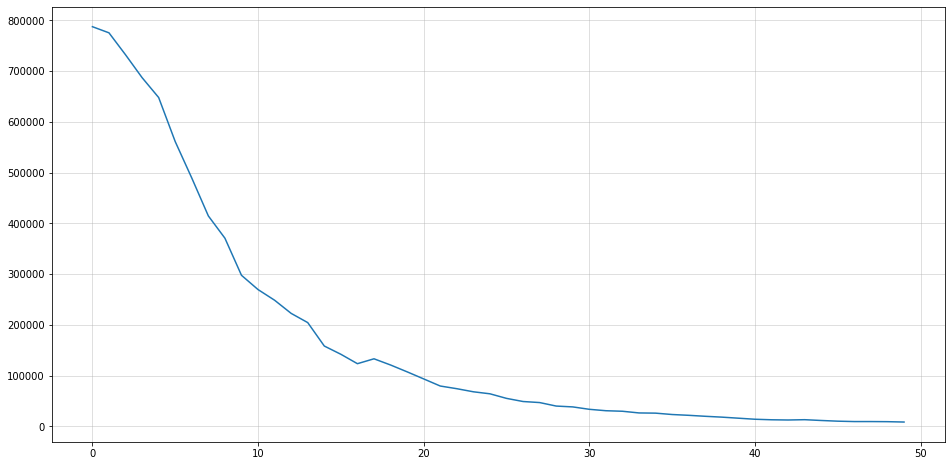

In [48]:
plt.figure(figsize=(16,8))
plt.plot(losses)
plt.grid(alpha=0.5)
plt.show()

In [16]:
output = model.forward(X, A)
test_x = torch.index_select(output, 0, test)
test_y = torch.index_select(y, 0, test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [17]:
predictions = test_x

In [18]:
predictions.shape

torch.Size([733, 50])

In [19]:
predictions, test_y = predictions.detach().numpy(), test_y.numpy()

In [36]:
king_index = dataset.word2id["father"]
queen_index = dataset.word2id["mother"]
man_index = dataset.word2id["man"]
woman_index = dataset.word2id["woman"]

check_words = ["think", "apples", "guarding", "ugliest", "cat", "in", "sixteen"]

print("KING : QUEEN, MAN : WOMAN", my_loss(output[king_index]-output[queen_index]+output[woman_index], output[man_index]))

for check_word in check_words:
  pal_index = dataset.word2id[check_word]
  print("KING : QUEEN,", check_word.upper(), ": WOMAN", my_loss(output[king_index]-output[queen_index]+output[woman_index], output[pal_index]))



  # ic(output[king_index]+output[queen_index]-output[woman_index])
  # ic(output[man_index])
  # ic(y[man_index])

# kq = output[king_index]-output[queen_index]
# mw = output[woman_index]-output[man_index]

# ic(kq)
# ic(mw)

# ic(abs(kq-mw))

KING : QUEEN, MAN : WOMAN tensor(684.1567, grad_fn=<MeanBackward0>)
KING : QUEEN, THINK : WOMAN tensor(722.6337, grad_fn=<MeanBackward0>)
KING : QUEEN, APPLES : WOMAN tensor(2009.2284, grad_fn=<MeanBackward0>)
KING : QUEEN, GUARDING : WOMAN tensor(2727.8784, grad_fn=<MeanBackward0>)
KING : QUEEN, UGLIEST : WOMAN tensor(2820.1250, grad_fn=<MeanBackward0>)
KING : QUEEN, CAT : WOMAN tensor(2820.7300, grad_fn=<MeanBackward0>)
KING : QUEEN, IN : WOMAN tensor(29196.3594, grad_fn=<MeanBackward0>)
KING : QUEEN, SIXTEEN : WOMAN tensor(2203.2769, grad_fn=<MeanBackward0>)
